Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


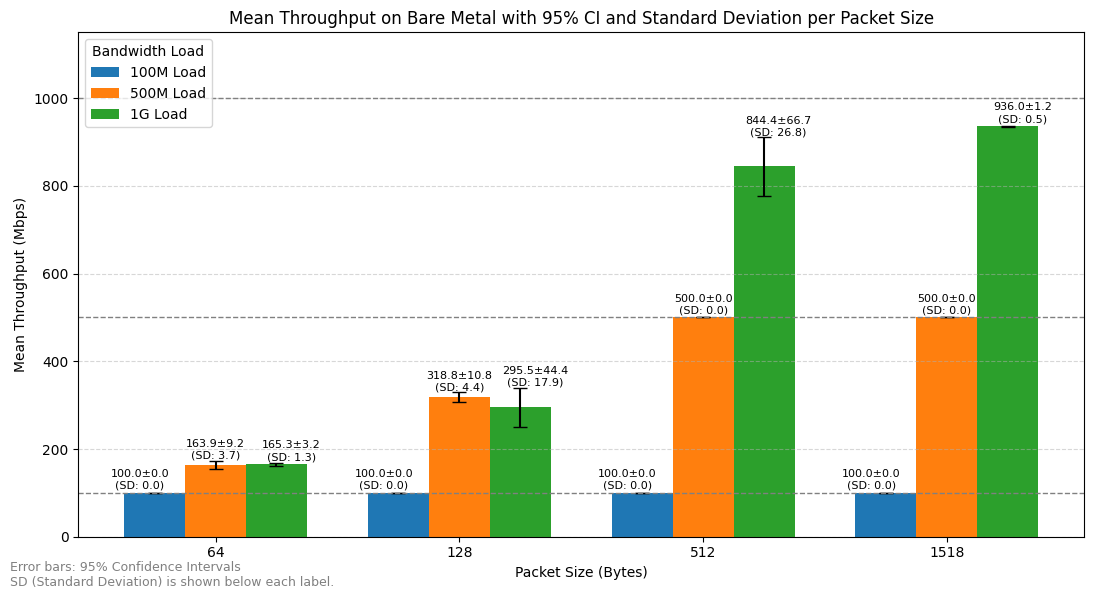

In [9]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Directory containing the iperf JSON results
base_path = "/content/drive/MyDrive/Test files/BM/throughput/multiple runs"

# Test parameters
bandwidths = ["100M", "500M", "1G"]
packet_sizes = ["64", "128", "512", "1518"]

# Data container
raw_data = {bw: {pkt: [] for pkt in packet_sizes} for bw in bandwidths}

# Load JSON results
for bw in bandwidths:
    for pkt in packet_sizes:
        for run in range(1, 4):  # Assuming 3 test runs
            filename = f"iperf_{bw}_{pkt}B_run{run}.json"
            file_path = os.path.join(base_path, filename)
            if os.path.exists(file_path):
                with open(file_path, 'r') as f:
                    data = json.load(f)
                    try:
                        bps = data['end']['sum_received']['bits_per_second']
                        mbps = bps / 1e6
                        raw_data[bw][pkt].append(mbps)
                    except KeyError:
                        print(f"⚠️ Missing expected keys in: {filename}")
            else:
                print(f"⚠️ File not found: {filename}")

# Calculate mean, 95% CI, and SD
throughput_data = {}
for bw in bandwidths:
    means, cis, sds = [], [], []
    for pkt in packet_sizes:
        values = raw_data[bw][pkt]
        if len(values) > 1:
            mean = np.mean(values)
            sd = np.std(values, ddof=1)
            ci = stats.t.interval(0.95, len(values)-1, loc=mean, scale=stats.sem(values))
            half_ci_width = (ci[1] - ci[0]) / 2
        elif len(values) == 1:
            mean = values[0]
            sd = 0.0
            half_ci_width = 0.0
        else:
            mean = sd = half_ci_width = 0.0
        means.append(mean)
        cis.append(half_ci_width)
        sds.append(sd)
    throughput_data[bw] = (means, cis, sds)

# Plotting
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
x = np.arange(len(packet_sizes))
bar_width = 0.25

plt.figure(figsize=(11, 6))

for i, (bw, color) in enumerate(zip(bandwidths, colors)):
    means, cis, sds = throughput_data[bw]
    offset = x + (i - 1) * bar_width
    bars = plt.bar(offset, means, yerr=cis, width=bar_width, label=f"{bw} Load", capsize=5, color=color)

    for j, bar in enumerate(bars):
        mean_val = means[j]
        ci_val = cis[j]
        sd_val = sds[j]
        label = f"{mean_val:.1f}±{ci_val:.1f}\n(SD: {sd_val:.1f})"
        align_shift = {-1: -0.06, 0: 0.0, 1: 0.06}[i - 1]
        plt.text(bar.get_x() + bar.get_width() / 2 + align_shift,
                 mean_val + max(ci_val, 5),
                 label, ha='center', va='bottom', fontsize=8)

# Final formatting
plt.xticks(x, [str(p) for p in packet_sizes])
plt.xlabel("Packet Size (Bytes)")
plt.ylabel("Mean Throughput (Mbps)")
plt.title("Mean Throughput on Bare Metal with 95% CI and Standard Deviation per Packet Size")

for y in [100, 500, 1000]:
    plt.axhline(y=y, color='gray', linestyle='--', linewidth=1)

plt.legend(title="Bandwidth Load")
plt.figtext(0.01, 0.01, "Error bars: 95% Confidence Intervals\nSD (Standard Deviation) is shown below each label.",
            ha='left', va='bottom', fontsize=9, color='gray')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.ylim(0, 1150)
plt.tight_layout()
plt.show()
